In [302]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sklearn.metrics
from sklearn.metrics import classification_report,accuracy_score,precision_recall_fscore_support

In [229]:
ETHNICITIES = ['African','Asian (East)', 'Asian (South)','Caucasian (American)','Caucasian (European)']
GENDERS = ['men','women']
METHODS = ['wav2lip','fsgan','faceswap']

# Read and Gather Predictions for Each Model

In [222]:
def get_id(path):
    return path.split('/')[-2]
    
def get_filename(path):
    return path.split('/')[-1]


def get_method(df,meta_df):
    """
        get deepfake generation method
    """
    
    methods = ['real'] * len(df)
    for index, row in df.iterrows():
        if row['label'] == 0:
            continue
            
        cond = (meta_df['source'] == row['source_id']) & (meta_df['path'] == row['filename'])
        method = meta_df[cond]['method'].values[0]
        methods[index] = method
        
    return methods

In [227]:
def filter_predictions(df,method):
    
    real_ids = df[df['label'] == 0]['source_id']
    fake_ids = df[(df['label'] == 1) & (df['method'] == method)]['source_id']
    fake_indices = []
    for real_id in real_ids:
        ids = fake_ids[fake_ids == real_id]
        if len(ids) > 0:
            fake_indices.append(ids.index[0])
    
    indices = list(real_ids.index) + fake_indices
    df =  df.iloc[indices].reset_index()
    df = df.drop(columns=['index'])
    return df
    

In [223]:
## Read prediction files for each model and join real and fake results
result_dir = './Predictions/pred_ensembles'
df_dict = {}
meta_df = pd.read_csv('./FakeAVCeleb_v1.2/meta_data.csv')
for model_name in os.listdir(result_dir):
    if '.DS_' in model_name:
        continue
    df_list = []
    for cat in os.listdir(os.path.join(result_dir,model_name)):
        if '.DS_' in cat:
            continue
        for ethnicity in os.listdir(os.path.join(result_dir,model_name,cat)):
            if '.DS_' in ethnicity:
                continue
            for gender in os.listdir(os.path.join(result_dir,model_name,cat,ethnicity)):
                if '.DS_' in gender:
                    continue
                
                path_df = os.path.join(result_dir,model_name,cat,ethnicity,gender,'results.csv')
                df = pd.read_csv(path_df)
                df_list.append(df)


    # concatenate all dfs for a model
    model_df = pd.concat(df_list).reset_index()
    model_df['path'] = model_df['path'].astype(str)
    model_df['source_id'] = model_df['path'].apply(get_id)
    model_df['filename'] = model_df['path'].apply(get_filename)
    model_df['method'] = get_method(model_df,meta_df)
    model_df = model_df.drop(columns=['index'])
    df_dict[model_name[4:]] = model_df


In [323]:
def get_label(path):
    if 'RealVideo' in path:
        return 0
    else:
        return 1

df_cvit = pd.read_csv('./preds_cross_efficient_transformer.txt')
df_cvit = df_cvit.rename(columns={'video_name':'path'})
df_cvit['path'] = df_cvit['path'].astype(str)
df_cvit['label'] = df_cvit['path'].apply(get_label)
df_cvit['source_id'] = df_cvit['path'].apply(get_id)
df_cvit['filename'] = df_cvit['path'].apply(get_filename)
df_cvit['method'] = get_method(df_cvit,meta_df)
df_cvit['gender'] = df_cvit['path'].apply(lambda x : x.split('/')[-3])
df_cvit['ethnicity'] = df_cvit['path'].apply(lambda x : x.split('/')[-4])

df_dict['CrossEffViT_DFDC_FFPP'] = df_cvit

In [231]:
df_dict.keys()

dict_keys(['EfficientNetB4_DFDC', 'EfficientNetB4_FFPP', 'EfficientNetAutoAttnB4_DFDC', 'EfficientNetB4ST_FFPP', 'Xception_DFDC', 'EfficientNetAutoAttnB4ST_FFPP', 'EfficientNetAutoAttnB4ST_DFDC', 'EfficientNetAutoAttnB4_FFPP', 'EfficientNetB4ST_DFDC', 'Xception_FFPP'])

Since we have an imbalanced dataset, we choose only one fake generated video against each real video for each generation method. We will evaluate the results on the three different generation methods separately. 

In [235]:
METHOD = 'fsgan'
for k in df_dict.keys():
    df_dict[k] = filter_predictions(df_dict[k],method = METHOD)

### Functions

In [288]:
def get_accuracy_scores(df,thresh = 0.5):
    
    preds_proba = df['pred'].to_numpy()
    preds = np.where(preds_proba >= thresh,1,0)
    
    labels = df['label'].to_numpy()
    stats = precision_recall_fscore_support(labels,preds)
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(labels,preds_proba,pos_label=1)
    auc = sklearn.metrics.roc_auc_score(labels,preds_proba)
    stats_dict= {
        'precision_0' : stats[0][0],
        'precision_1' : stats[0][1],
        'recall_0' : stats[1][0],
        'recall_1' : stats[1][1],
        'f1_0': stats[2][0],
        'f1_1' : stats[2][1],
        'tpr': tpr,
        'fpr': fpr,
        'thresholds-roc': thresholds,
        'auc-roc':auc
    }
    
    
    return accuracy_score(labels,preds),stats_dict

def get_accuracy_scores_ethnicity(df,ethnicity,thresh=0.5):
    cond = df['ethnicity'] == ethnicity
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict

def get_accuracy_scores_gender(df,gender,thresh=0.5):
    cond = df['gender'] == gender
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict


def get_accuracy_scores_ethnicity_gender(df,ethnicity,gender,thresh=0.5):
    cond = (df['gender'] == gender) & (df['ethnicity'] == ethnicity)
    df_filter = df[cond]
    
    acc,stats_dict = get_accuracy_scores(df_filter,thresh)
    return acc,stats_dict


# Accuracy Analysis

### Accuracy of Each Model Overall

In [328]:
accs = []
datasets = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    acc,stats_dict = get_accuracy_scores(df)
    accs.append(acc)
    precision_0.append(stats_dict['precision_0'])
    precision_1.append(stats_dict['precision_1'])
    recall_0.append(stats_dict['recall_0'])
    recall_1.append(stats_dict['recall_1'])
    f1_0.append(stats_dict['f1_0'])
    f1_1.append(stats_dict['f1_1'])
    tpr.append(stats_dict['tpr'])
    fpr.append(stats_dict['fpr'])
    thresholds_roc.append(stats_dict['thresholds-roc'])
    auc_roc.append(stats_dict['auc-roc'])
    
    if model_name.startswith('CrossEff'):
        datasets.append('DFDC_FFPP')
        model_names.append('CrossEffViT')
    else:
        datasets.append(model_name.split('_')[-1])
        model_names.append(model_name.split('_')[0])

accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
6,EfficientNetAutoAttnB4ST,DFDC,0.711066,0.720648,0.701245,0.712,0.710084,0.716298,0.705637,"[0.0, 0.0021008403361344537, 0.008403361344537...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.006, 0.006, 0....","[1.97906345, 0.97906345, 0.97580564, 0.9757229...",0.787782
0,EfficientNetB4,DFDC,0.728484,0.791563,0.684119,0.638,0.823529,0.706534,0.747378,"[0.0, 0.0021008403361344537, 0.174369747899159...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9998103999999999, 0.9998104, 0.99143654, 0....",0.827803
8,EfficientNetB4ST,DFDC,0.741803,0.751012,0.732365,0.742,0.741597,0.746479,0.736952,"[0.0, 0.0021008403361344537, 0.090336134453781...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.98643327, 0.98643327, 0.96613556, 0.9651468...",0.828353
2,EfficientNetAutoAttnB4,DFDC,0.752049,0.784141,0.724138,0.712,0.794118,0.746331,0.757515,"[0.0, 0.0021008403361344537, 0.186974789915966...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.006, 0.006, 0....","[1.9994942999999998, 0.9994943, 0.9872464, 0.9...",0.842181
4,Xception,DFDC,0.770492,0.727723,0.840541,0.882,0.653361,0.797468,0.735225,"[0.0, 0.0021008403361344537, 0.086134453781512...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.99913365, 0.99913365, 0.988603, 0.98833966,...",0.855328
9,Xception,FFPP,0.804303,0.750405,0.896936,0.926,0.676471,0.829006,0.771257,"[0.0, 0.0021008403361344537, 0.220588235294117...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.006, 0.006, 0....","[1.99888116, 0.99888116, 0.94871444, 0.9486518...",0.895475
7,EfficientNetAutoAttnB4,FFPP,0.778689,0.717791,0.901235,0.936,0.613445,0.812500,0.730000,"[0.0, 0.0021008403361344537, 0.107142857142857...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.99757713, 0.99757713, 0.96215576, 0.9613452...",0.906916
5,EfficientNetAutoAttnB4ST,FFPP,0.787910,0.722307,0.924290,0.952,0.615546,0.821398,0.738966,"[0.0, 0.0021008403361344537, 0.277310924369747...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.9758723, 0.9758723, 0.8106115, 0.81034005, ...",0.919664
3,EfficientNetB4ST,FFPP,0.827869,0.786207,0.888889,0.912,0.739496,0.844444,0.807339,"[0.0, 0.0021008403361344537, 0.376050420168067...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.99321496, 0.99321496, 0.8698055, 0.8694447,...",0.929088
1,EfficientNetB4,FFPP,0.838115,0.794828,0.901515,0.922,0.750000,0.853704,0.818807,"[0.0, 0.0021008403361344537, 0.258403361344537...","[0.0, 0.0, 0.0, 0.002, 0.002, 0.004, 0.004, 0....","[1.99913687, 0.99913687, 0.9446316, 0.9435221,...",0.939941


In [340]:
cols_to_use = ['model',	'training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
accuracy_df = accuracy_df.round(decimals=2)
accuracy_df[cols_to_use].to_csv('./tables/overall_fsgan.csv',index=False)

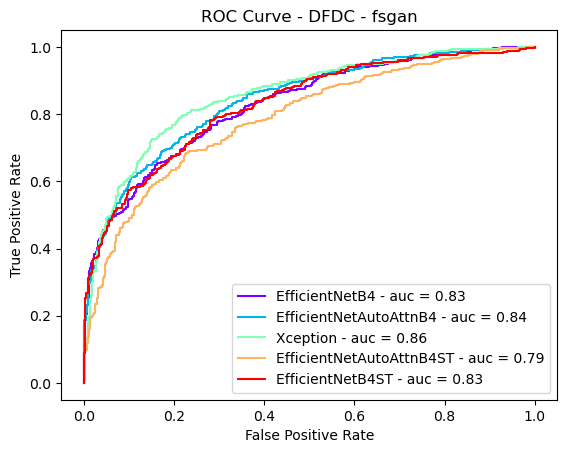

In [303]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'DFDC']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DFDC - fsgan")
plt.legend(loc="lower right")
plt.show()

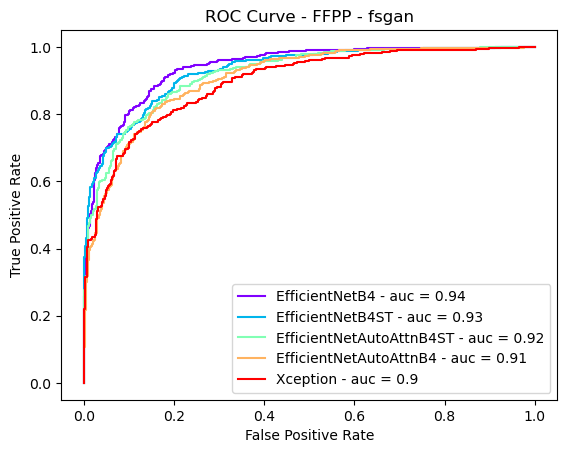

In [322]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'FFPP']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FFPP - fsgan")
plt.legend(loc="lower right")
plt.show()

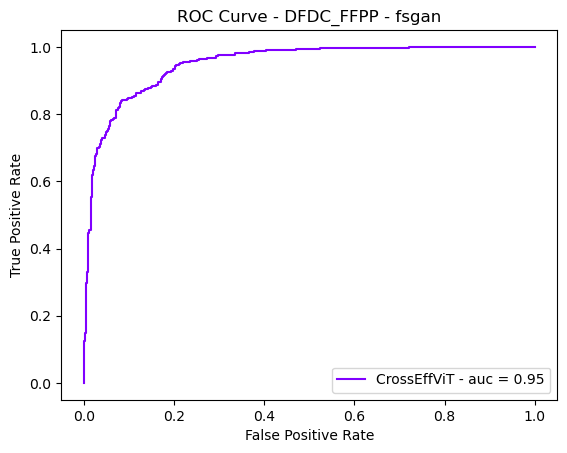

In [341]:
# plot roc curves
plt.style.use('default')
plt.figure()
temp_df = accuracy_df[accuracy_df['training_dataset'] == 'DFDC_FFPP']
colors = iter(cm.rainbow(np.linspace(0, 1, len(temp_df))))
for i,row in temp_df.iterrows():
    tpr = row['tpr']
    fpr = row['fpr']
    auc = row['auc-roc']
    l = row['model']  + ' - auc = ' + str(str(round(auc, 2)))
    plt.plot(fpr,tpr,color=next(colors),label = l)
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DFDC_FFPP - fsgan")
plt.legend(loc="lower right")
plt.show()

## Ethnic Group

In [347]:
accs = []
datasets = []
ethnics = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []
for model_name,df in df_dict.items():
    
    for eth in ETHNICITIES:
        acc,stats_dict = get_accuracy_scores_ethnicity(df,eth)
        ethnics.append(eth)
        accs.append(acc)
        precision_0.append(stats_dict['precision_0'])
        precision_1.append(stats_dict['precision_1'])
        recall_0.append(stats_dict['recall_0'])
        recall_1.append(stats_dict['recall_1'])
        f1_0.append(stats_dict['f1_0'])
        f1_1.append(stats_dict['f1_1'])
        tpr.append(stats_dict['tpr'])
        fpr.append(stats_dict['fpr'])
        thresholds_roc.append(stats_dict['thresholds-roc'])
        auc_roc.append(stats_dict['auc-roc'])

        if model_name.startswith('CrossEff'):
            datasets.append('DFDC_FFPP')
            model_names.append('CrossEffViT')
        else:
            datasets.append(model_name.split('_')[-1])
            model_names.append(model_name.split('_')[0])


ethnic_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'ethnicity': ethnics,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

ethnic_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
33,EfficientNetAutoAttnB4ST,DFDC,Caucasian (American),0.690000,0.693878,0.686275,0.68,0.700000,0.686869,0.693069,"[0.0, 0.01, 0.11, 0.11, 0.18, 0.18, 0.31, 0.31...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97580564, 0.97580564, 0.9374298, 0.9340442,...",0.770500
31,EfficientNetAutoAttnB4ST,DFDC,Asian (East),0.698864,0.770115,0.629213,0.67,0.736842,0.716578,0.678788,"[0.0, 0.013157894736842105, 0.1315789473684210...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9776194999999999, 0.9776195, 0.9415087, 0.9...",0.774737
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.690000,0.675926,0.706522,0.73,0.650000,0.701923,0.677083,"[0.0, 0.01, 0.02, 0.02, 0.15, 0.15, 0.19, 0.19...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97906345, 0.97906345, 0.976046, 0.9757229, ...",0.776200
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.715000,0.712871,0.717172,0.72,0.710000,0.716418,0.713568,"[0.0, 0.01, 0.1, 0.1, 0.23, 0.23, 0.27, 0.27, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97498816, 0.97498816, 0.94630474, 0.9451262...",0.779200
23,Xception,DFDC,Caucasian (American),0.715000,0.656934,0.841270,0.90,0.530000,0.759494,0.650307,"[0.0, 0.01, 0.05, 0.05, 0.06, 0.06, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9984289, 0.9984289, 0.99463296, 0.98833966,...",0.791200
3,EfficientNetB4,DFDC,Caucasian (American),0.695000,0.719101,0.675676,0.64,0.750000,0.677249,0.710900,"[0.0, 0.01, 0.22, 0.22, 0.27, 0.27, 0.33, 0.33...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9990459999999999, 0.999046, 0.97652197, 0.9...",0.793100
43,EfficientNetB4ST,DFDC,Caucasian (American),0.720000,0.700000,0.744444,0.77,0.670000,0.733333,0.705263,"[0.0, 0.01, 0.28, 0.28, 0.32, 0.32, 0.33, 0.33...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9766138, 0.9766138, 0.91075075, 0.9057066, ...",0.797400
13,EfficientNetAutoAttnB4,DFDC,Caucasian (American),0.725000,0.710280,0.741935,0.76,0.690000,0.734300,0.715026,"[0.0, 0.01, 0.17, 0.17, 0.2, 0.2, 0.25, 0.25, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99913764, 0.99913764, 0.9797595, 0.9796246,...",0.797500
44,EfficientNetB4ST,DFDC,Caucasian (European),0.710000,0.690909,0.733333,0.76,0.660000,0.723810,0.694737,"[0.0, 0.01, 0.21, 0.21, 0.23, 0.23, 0.3, 0.3, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9823533, 0.9823533, 0.9424841, 0.94048065, ...",0.810000
2,EfficientNetB4,DFDC,Asian (South),0.720000,0.775000,0.683333,0.62,0.820000,0.688889,0.745455,"[0.0, 0.01, 0.26, 0.26, 0.29, 0.29, 0.39, 0.39...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9998103999999999, 0.9998104, 0.9899725, 0.9...",0.811600


In [348]:
cols_to_use = ['model',	'ethnicity','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
ethnic_accuracy_df = ethnic_accuracy_df.round(decimals=2)
ethnic_accuracy_df[cols_to_use].to_csv('./tables/ethnicities/fsgan.csv',index=False)

In [320]:
ethnic_accuracy_df.sort_values(by=['f1_1'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
23,Xception,DFDC,Caucasian (American),0.715000,0.656934,0.841270,0.90,0.530000,0.759494,0.650307,"[0.0, 0.01, 0.05, 0.05, 0.06, 0.06, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9984289, 0.9984289, 0.99463296, 0.98833966,...",0.791200
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.690000,0.675926,0.706522,0.73,0.650000,0.701923,0.677083,"[0.0, 0.01, 0.02, 0.02, 0.15, 0.15, 0.19, 0.19...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97906345, 0.97906345, 0.976046, 0.9757229, ...",0.776200
31,EfficientNetAutoAttnB4ST,DFDC,Asian (East),0.698864,0.770115,0.629213,0.67,0.736842,0.716578,0.678788,"[0.0, 0.013157894736842105, 0.1315789473684210...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9776194999999999, 0.9776195, 0.9415087, 0.9...",0.774737
25,EfficientNetAutoAttnB4ST,FFPP,African,0.755000,0.675862,0.963636,0.98,0.530000,0.800000,0.683871,"[0.0, 0.01, 0.5, 0.5, 0.64, 0.64, 0.66, 0.66, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.05, ...","[1.95635355, 0.95635355, 0.534084, 0.5092821, ...",0.925700
33,EfficientNetAutoAttnB4ST,DFDC,Caucasian (American),0.690000,0.693878,0.686275,0.68,0.700000,0.686869,0.693069,"[0.0, 0.01, 0.11, 0.11, 0.18, 0.18, 0.31, 0.31...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97580564, 0.97580564, 0.9374298, 0.9340442,...",0.770500
44,EfficientNetB4ST,DFDC,Caucasian (European),0.710000,0.690909,0.733333,0.76,0.660000,0.723810,0.694737,"[0.0, 0.01, 0.21, 0.21, 0.23, 0.23, 0.3, 0.3, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9823533, 0.9823533, 0.9424841, 0.94048065, ...",0.810000
38,EfficientNetAutoAttnB4,FFPP,Caucasian (American),0.755000,0.683453,0.918033,0.95,0.560000,0.794979,0.695652,"[0.0, 0.01, 0.36, 0.36, 0.43, 0.43, 0.45, 0.45...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9887644, 0.9887644, 0.7495187, 0.7445732, 0...",0.908300
28,EfficientNetAutoAttnB4ST,FFPP,Caucasian (American),0.760000,0.685714,0.933333,0.96,0.560000,0.800000,0.700000,"[0.0, 0.01, 0.45, 0.45, 0.47, 0.47, 0.53, 0.53...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9698728, 0.9698728, 0.67650896, 0.6633358, ...",0.911900
48,Xception,FFPP,Caucasian (American),0.760000,0.685714,0.933333,0.96,0.560000,0.800000,0.700000,"[0.0, 0.01, 0.34, 0.34, 0.39, 0.39, 0.46, 0.46...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.99566525, 0.99566525, 0.7807534, 0.77811664...",0.883900
43,EfficientNetB4ST,DFDC,Caucasian (American),0.720000,0.700000,0.744444,0.77,0.670000,0.733333,0.705263,"[0.0, 0.01, 0.28, 0.28, 0.32, 0.32, 0.33, 0.33...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9766138, 0.9766138, 0.91075075, 0.9057066, ...",0.797400


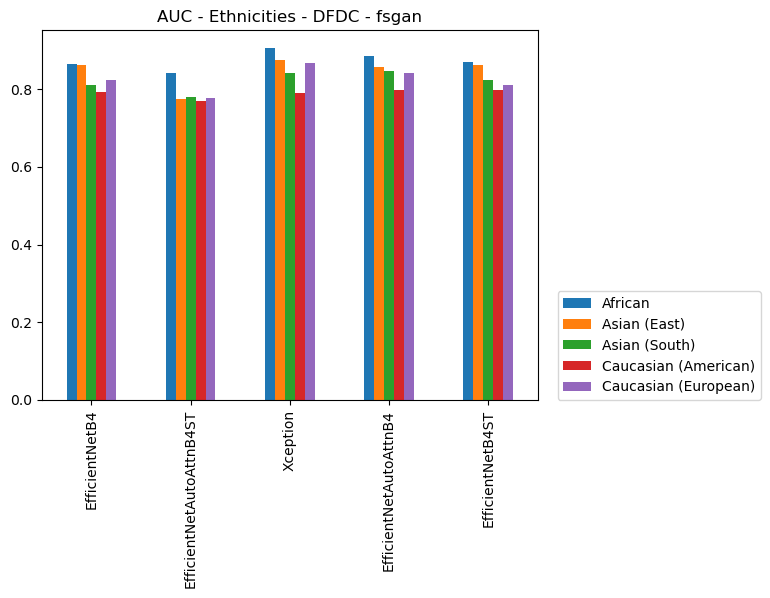

In [312]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
af_auc = []
ca_auc = []
ce_auc = []
ae_auc = []
as_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African')
    af_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)')
    ae_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)')
    as_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)')
    ca_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)')
    ce_auc.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African':af_auc,
    'Asian (East)':ae_auc,
    'Asian (South)':as_auc,
    'Caucasian (American)':ca_auc,
    'Caucasian (European)':ce_auc,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Ethnicities - DFDC - fsgan')
plt.legend(loc=(1.04,0))
plt.show()

In [306]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','ethnicity','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

            model             ethnicity  accuracy  auc-roc
3  EfficientNetB4  Caucasian (American)     0.695   0.7931
0  EfficientNetB4               African     0.750   0.8657
                       model             ethnicity  accuracy  auc-roc
33  EfficientNetAutoAttnB4ST  Caucasian (American)      0.69   0.7705
30  EfficientNetAutoAttnB4ST               African      0.76   0.8429
       model             ethnicity  accuracy  auc-roc
23  Xception  Caucasian (American)     0.715   0.7912
20  Xception               African     0.825   0.9063
                     model             ethnicity  accuracy  auc-roc
13  EfficientNetAutoAttnB4  Caucasian (American)     0.725   0.7975
10  EfficientNetAutoAttnB4               African     0.785   0.8858
               model             ethnicity  accuracy  auc-roc
43  EfficientNetB4ST  Caucasian (American)      0.72   0.7974
40  EfficientNetB4ST               African      0.78   0.8702


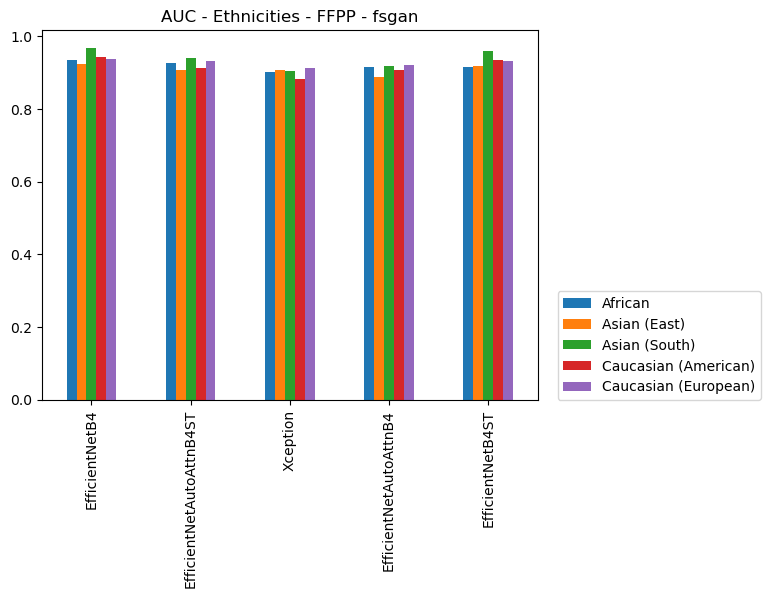

In [314]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
af_auc = []
ca_auc = []
ce_auc = []
ae_auc = []
as_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African')
    af_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)')
    ae_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)')
    as_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)')
    ca_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)')
    ce_auc.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African':af_auc,
    'Asian (East)':ae_auc,
    'Asian (South)':as_auc,
    'Caucasian (American)':ca_auc,
    'Caucasian (European)':ce_auc,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Ethnicities - FFPP - fsgan')
plt.legend(loc=(1.04,0))
plt.show()

In [307]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','ethnicity','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

            model      ethnicity  accuracy   auc-roc
6  EfficientNetB4   Asian (East)  0.857955  0.923026
7  EfficientNetB4  Asian (South)  0.885000  0.968100
                       model      ethnicity  accuracy   auc-roc
26  EfficientNetAutoAttnB4ST   Asian (East)  0.806818  0.907632
27  EfficientNetAutoAttnB4ST  Asian (South)  0.805000  0.941600
       model             ethnicity  accuracy  auc-roc
48  Xception  Caucasian (American)      0.76   0.8839
49  Xception  Caucasian (European)      0.81   0.9130
                     model             ethnicity  accuracy   auc-roc
36  EfficientNetAutoAttnB4          Asian (East)  0.801136  0.888289
39  EfficientNetAutoAttnB4  Caucasian (European)  0.800000  0.919800
               model      ethnicity  accuracy  auc-roc
15  EfficientNetB4ST        African     0.805   0.9150
17  EfficientNetB4ST  Asian (South)     0.885   0.9591


<AxesSubplot:title={'center':'AUC Ethnicities DFDC_FFPP fsgan'}, xlabel='ethnicity'>

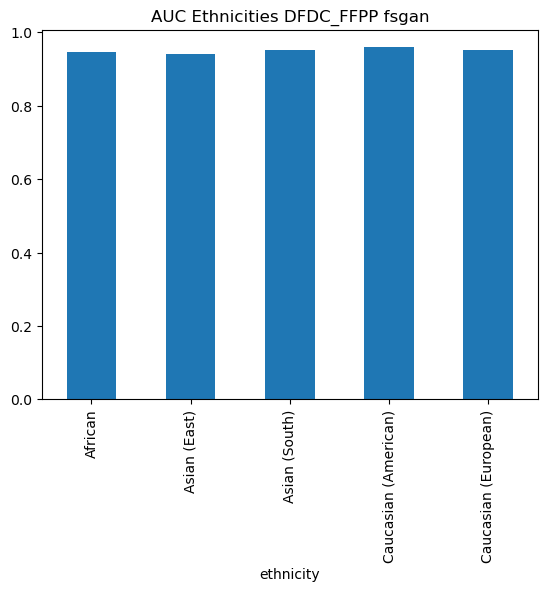

In [335]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.plot.bar(x='ethnicity',y='auc-roc',title='AUC Ethnicities DFDC_FFPP fsgan',legend=False)

#### Groups with low to high accuracy ( models trained on DFDC )

In [291]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
33,EfficientNetAutoAttnB4ST,DFDC,Caucasian (American),0.690000,0.693878,0.686275,0.68,0.700000,0.686869,0.693069,"[0.0, 0.01, 0.11, 0.11, 0.18, 0.18, 0.31, 0.31...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97580564, 0.97580564, 0.9374298, 0.9340442,...",0.770500
31,EfficientNetAutoAttnB4ST,DFDC,Asian (East),0.698864,0.770115,0.629213,0.67,0.736842,0.716578,0.678788,"[0.0, 0.013157894736842105, 0.1315789473684210...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9776194999999999, 0.9776195, 0.9415087, 0.9...",0.774737
34,EfficientNetAutoAttnB4ST,DFDC,Caucasian (European),0.690000,0.675926,0.706522,0.73,0.650000,0.701923,0.677083,"[0.0, 0.01, 0.02, 0.02, 0.15, 0.15, 0.19, 0.19...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97906345, 0.97906345, 0.976046, 0.9757229, ...",0.776200
32,EfficientNetAutoAttnB4ST,DFDC,Asian (South),0.715000,0.712871,0.717172,0.72,0.710000,0.716418,0.713568,"[0.0, 0.01, 0.1, 0.1, 0.23, 0.23, 0.27, 0.27, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.97498816, 0.97498816, 0.94630474, 0.9451262...",0.779200
23,Xception,DFDC,Caucasian (American),0.715000,0.656934,0.841270,0.90,0.530000,0.759494,0.650307,"[0.0, 0.01, 0.05, 0.05, 0.06, 0.06, 0.18, 0.18...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9984289, 0.9984289, 0.99463296, 0.98833966,...",0.791200
3,EfficientNetB4,DFDC,Caucasian (American),0.695000,0.719101,0.675676,0.64,0.750000,0.677249,0.710900,"[0.0, 0.01, 0.22, 0.22, 0.27, 0.27, 0.33, 0.33...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9990459999999999, 0.999046, 0.97652197, 0.9...",0.793100
43,EfficientNetB4ST,DFDC,Caucasian (American),0.720000,0.700000,0.744444,0.77,0.670000,0.733333,0.705263,"[0.0, 0.01, 0.28, 0.28, 0.32, 0.32, 0.33, 0.33...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9766138, 0.9766138, 0.91075075, 0.9057066, ...",0.797400
13,EfficientNetAutoAttnB4,DFDC,Caucasian (American),0.725000,0.710280,0.741935,0.76,0.690000,0.734300,0.715026,"[0.0, 0.01, 0.17, 0.17, 0.2, 0.2, 0.25, 0.25, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99913764, 0.99913764, 0.9797595, 0.9796246,...",0.797500
44,EfficientNetB4ST,DFDC,Caucasian (European),0.710000,0.690909,0.733333,0.76,0.660000,0.723810,0.694737,"[0.0, 0.01, 0.21, 0.21, 0.23, 0.23, 0.3, 0.3, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9823533, 0.9823533, 0.9424841, 0.94048065, ...",0.810000
2,EfficientNetB4,DFDC,Asian (South),0.720000,0.775000,0.683333,0.62,0.820000,0.688889,0.745455,"[0.0, 0.01, 0.26, 0.26, 0.29, 0.29, 0.39, 0.39...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9998103999999999, 0.9998104, 0.9899725, 0.9...",0.811600


#### Groups with low to high accuracy ( models trained on FFPP)

In [292]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
48,Xception,FFPP,Caucasian (American),0.760000,0.685714,0.933333,0.96,0.560000,0.800000,0.700000,"[0.0, 0.01, 0.34, 0.34, 0.39, 0.39, 0.46, 0.46...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.99566525, 0.99566525, 0.7807534, 0.77811664...",0.883900
36,EfficientNetAutoAttnB4,FFPP,Asian (East),0.801136,0.787611,0.825397,0.89,0.684211,0.835681,0.748201,"[0.0, 0.013157894736842105, 0.3026315789473684...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.03, 0.04, ...","[1.9955755499999999, 0.99557555, 0.89789814, 0...",0.888289
45,Xception,FFPP,African,0.785000,0.717557,0.913043,0.94,0.630000,0.813853,0.745562,"[0.0, 0.01, 0.34, 0.34, 0.35, 0.35, 0.55, 0.55...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9924625, 0.9924625, 0.81036377, 0.7977816, ...",0.900700
47,Xception,FFPP,Asian (South),0.845000,0.805310,0.896552,0.91,0.780000,0.854460,0.834225,"[0.0, 0.01, 0.31, 0.31, 0.53, 0.53, 0.54, 0.54...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.04, ...","[1.9960452, 0.9960452, 0.95081985, 0.9486518, ...",0.904000
26,EfficientNetAutoAttnB4ST,FFPP,Asian (East),0.806818,0.794643,0.828125,0.89,0.697368,0.839623,0.757143,"[0.0, 0.013157894736842105, 0.3815789473684211...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9758723, 0.9758723, 0.81094414, 0.81034005,...",0.907632
46,Xception,FFPP,Asian (East),0.823864,0.816514,0.835821,0.89,0.736842,0.851675,0.783217,"[0.0, 0.013157894736842105, 0.3289473684210526...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.05, ...","[1.9944159, 0.9944159, 0.89766234, 0.8963505, ...",0.908158
38,EfficientNetAutoAttnB4,FFPP,Caucasian (American),0.755000,0.683453,0.918033,0.95,0.560000,0.794979,0.695652,"[0.0, 0.01, 0.36, 0.36, 0.43, 0.43, 0.45, 0.45...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9887644, 0.9887644, 0.7495187, 0.7445732, 0...",0.908300
28,EfficientNetAutoAttnB4ST,FFPP,Caucasian (American),0.760000,0.685714,0.933333,0.96,0.560000,0.800000,0.700000,"[0.0, 0.01, 0.45, 0.45, 0.47, 0.47, 0.53, 0.53...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9698728, 0.9698728, 0.67650896, 0.6633358, ...",0.911900
49,Xception,FFPP,Caucasian (European),0.810000,0.750000,0.907895,0.93,0.690000,0.830357,0.784091,"[0.0, 0.01, 0.51, 0.51, 0.59, 0.59, 0.61, 0.61...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.05, 0.05, 0.06, ...","[1.99888116, 0.99888116, 0.800199, 0.79778427,...",0.913000
15,EfficientNetB4ST,FFPP,African,0.805000,0.732824,0.942029,0.96,0.650000,0.831169,0.769231,"[0.0, 0.01, 0.47, 0.47, 0.56, 0.56, 0.61, 0.61...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99321496, 0.99321496, 0.7623155, 0.7365489,...",0.915000


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP)

In [333]:
temp_df = ethnic_accuracy_df[ethnic_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
51,CrossEffViT,DFDC_FFPP,Asian (East),0.869318,0.896907,0.835443,0.87,0.868421,0.883249,0.851613,"[0.0, 0.013157894736842105, 0.0789473684210526...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9999383, 0.9999383, 0.9973873, 0.99694365, ...",0.941316
50,CrossEffViT,DFDC_FFPP,African,0.860000,0.852941,0.867347,0.87,0.850000,0.861386,0.858586,"[0.0, 0.01, 0.2, 0.2, 0.51, 0.51, 0.75, 0.75, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.99995595, 0.99995595, 0.99566203, 0.9951516...",0.947200
52,CrossEffViT,DFDC_FFPP,Asian (South),0.855000,0.819820,0.898876,0.91,0.800000,0.862559,0.846561,"[0.0, 0.01, 0.39, 0.39, 0.64, 0.64, 0.7, 0.7, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.9999428, 0.9999428, 0.95427734, 0.952275, 0...",0.951300
54,CrossEffViT,DFDC_FFPP,Caucasian (European),0.900000,0.884615,0.916667,0.92,0.880000,0.901961,0.897959,"[0.0, 0.01, 0.45, 0.45, 0.65, 0.65, 0.69, 0.69...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.03, 0.03, 0.04, ...","[1.9999343, 0.9999343, 0.91717345, 0.91019475,...",0.952300
53,CrossEffViT,DFDC_FFPP,Caucasian (American),0.885000,0.846847,0.932584,0.94,0.830000,0.890995,0.878307,"[0.0, 0.01, 0.26, 0.26, 0.45, 0.45, 0.67, 0.67...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, ...","[1.999933, 0.999933, 0.9623065, 0.9606824, 0.8...",0.958900


## Gender Group

In [349]:
accs = []
datasets = []
genders = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    
    for gender in GENDERS:
        acc,stats_dict = get_accuracy_scores_gender(df,gender)
        accs.append(acc)
        genders.append(gender)
        precision_0.append(stats_dict['precision_0'])
        precision_1.append(stats_dict['precision_1'])
        recall_0.append(stats_dict['recall_0'])
        recall_1.append(stats_dict['recall_1'])
        f1_0.append(stats_dict['f1_0'])
        f1_1.append(stats_dict['f1_1'])
        tpr.append(stats_dict['tpr'])
        fpr.append(stats_dict['fpr'])
        thresholds_roc.append(stats_dict['thresholds-roc'])
        auc_roc.append(stats_dict['auc-roc'])

        if model_name.startswith('CrossEff'):
            datasets.append('DFDC_FFPP')
            model_names.append('CrossEffViT')
        else:
            datasets.append(model_name.split('_')[-1])
            model_names.append(model_name.split('_')[0])


gender_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'gender': genders,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

gender_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
13,EfficientNetAutoAttnB4ST,DFDC,women,0.716867,0.673016,0.792350,0.848,0.584677,0.750442,0.672854,"[0.0, 0.004032258064516129, 0.1129032258064516...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.966984, 0.966984, 0.92291856, 0.91895264, 0...",0.786355
1,EfficientNetB4,DFDC,women,0.744980,0.746988,0.742972,0.744,0.745968,0.745491,0.744467,"[0.0, 0.004032258064516129, 0.1048387096774193...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99952817, 0.99952817, 0.99166286, 0.9913204...",0.817806
12,EfficientNetAutoAttnB4ST,DFDC,men,0.705021,0.804469,0.645485,0.576,0.846491,0.671329,0.732448,"[0.0, 0.0043859649122807015, 0.017543859649122...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.97906345, 0.97906345, 0.97580564, 0.9757229...",0.826228
5,EfficientNetAutoAttnB4,DFDC,women,0.748996,0.755102,0.743083,0.740,0.758065,0.747475,0.750499,"[0.0, 0.004032258064516129, 0.1370967741935483...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9994646999999999, 0.9994647, 0.98772883, 0....",0.833097
17,EfficientNetB4ST,DFDC,women,0.738956,0.702703,0.792079,0.832,0.645161,0.761905,0.711111,"[0.0, 0.004032258064516129, 0.1411290322580645...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9806559, 0.9806559, 0.941086, 0.94048065, 0...",0.834435
9,Xception,DFDC,women,0.740964,0.685015,0.847953,0.896,0.584677,0.776430,0.692124,"[0.0, 0.004032258064516129, 0.1048387096774193...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9983059, 0.9983059, 0.9825963, 0.9824013, 0...",0.840468
16,EfficientNetB4ST,DFDC,men,0.744770,0.823232,0.689286,0.652,0.846491,0.727679,0.759843,"[0.0, 0.0043859649122807015, 0.153508771929824...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.98643327, 0.98643327, 0.96613556, 0.9651468...",0.849667
4,EfficientNetAutoAttnB4,DFDC,men,0.755230,0.818182,0.706320,0.684,0.833333,0.745098,0.764588,"[0.0, 0.0043859649122807015, 0.241228070175438...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9994942999999998, 0.9994943, 0.9872464, 0.9...",0.855947
0,EfficientNetB4,DFDC,men,0.711297,0.863636,0.638889,0.532,0.907895,0.658416,0.750000,"[0.0, 0.0043859649122807015, 0.258771929824561...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9998103999999999, 0.9998104, 0.99070275, 0....",0.860088
8,Xception,DFDC,men,0.801255,0.777778,0.834171,0.868,0.728070,0.820416,0.777518,"[0.0, 0.0043859649122807015, 0.122807017543859...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99913365, 0.99913365, 0.988603, 0.98833966,...",0.874561


In [350]:
cols_to_use = ['model',	'gender','training_dataset',	'accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
gender_accuracy_df = gender_accuracy_df.round(decimals=2)
gender_accuracy_df[cols_to_use].to_csv('./tables/gender/fsgan.csv',index=False)

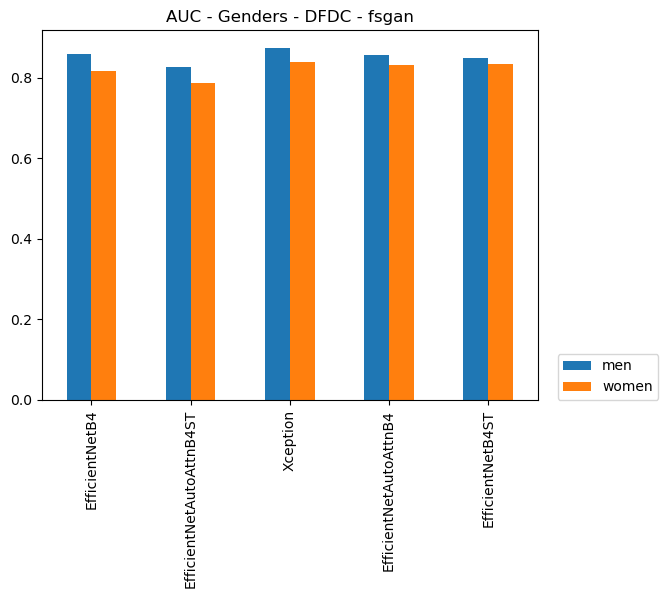

In [317]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
m_auc = []
w_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['gender']=='men')
    m_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['gender']=='women')
    w_auc.append(temp_df[cond]['auc-roc'].values[0])
    
    
d_b = pd.DataFrame({
    'men':m_auc,
    'women':w_auc
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Genders - DFDC - fsgan')
plt.legend(loc=(1.04,0))
plt.show()

In [308]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

            model gender  accuracy   auc-roc
1  EfficientNetB4  women  0.744980  0.817806
0  EfficientNetB4    men  0.711297  0.860088
                       model gender  accuracy   auc-roc
13  EfficientNetAutoAttnB4ST  women  0.716867  0.786355
12  EfficientNetAutoAttnB4ST    men  0.705021  0.826228
      model gender  accuracy   auc-roc
9  Xception  women  0.740964  0.840468
8  Xception    men  0.801255  0.874561
                    model gender  accuracy   auc-roc
5  EfficientNetAutoAttnB4  women  0.748996  0.833097
4  EfficientNetAutoAttnB4    men  0.755230  0.855947
               model gender  accuracy   auc-roc
17  EfficientNetB4ST  women  0.738956  0.834435
16  EfficientNetB4ST    men  0.744770  0.849667


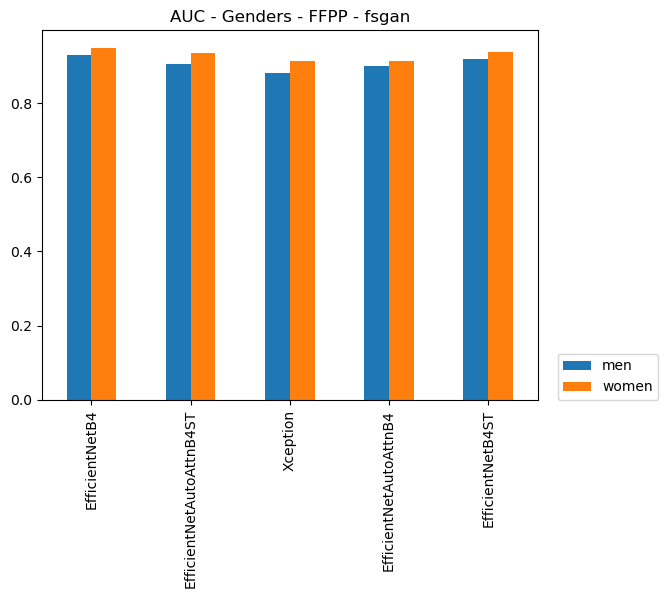

In [318]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
m_auc = []
w_auc = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['gender']=='men')
    m_auc.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['gender']=='women')
    w_auc.append(temp_df[cond]['auc-roc'].values[0])
    
    
d_b = pd.DataFrame({
    'men':m_auc,
    'women':w_auc
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Genders - FFPP - fsgan')
plt.legend(loc=(1.04,0))
plt.show()

In [309]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

            model gender  accuracy   auc-roc
2  EfficientNetB4    men  0.828452  0.930614
3  EfficientNetB4  women  0.847390  0.948484
                       model gender  accuracy   auc-roc
10  EfficientNetAutoAttnB4ST    men  0.769874  0.905947
11  EfficientNetAutoAttnB4ST  women  0.805221  0.934145
       model gender  accuracy   auc-roc
18  Xception    men  0.774059  0.882140
19  Xception  women  0.833333  0.914258
                     model gender  accuracy   auc-roc
14  EfficientNetAutoAttnB4    men  0.769874  0.898509
15  EfficientNetAutoAttnB4  women  0.787149  0.914306
              model gender  accuracy   auc-roc
6  EfficientNetB4ST    men  0.815900  0.919351
7  EfficientNetB4ST  women  0.839357  0.938694


<AxesSubplot:title={'center':'AUC Gender DFDC_FFPP fsgan'}, xlabel='gender'>

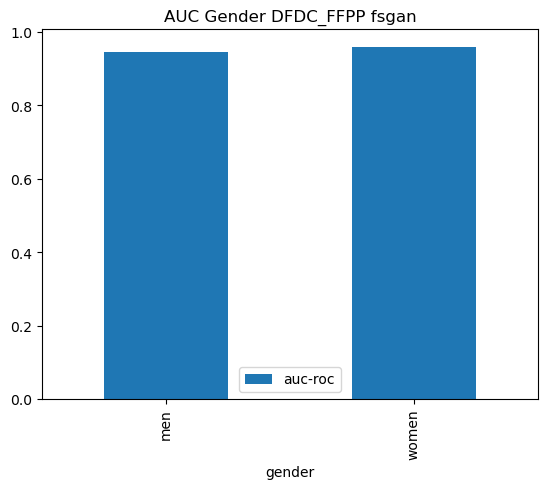

In [336]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.plot.bar(x='gender',y='auc-roc',title='AUC Gender DFDC_FFPP fsgan')

#### Groups with low to high accuracy ( models trained on DFDC )

In [295]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
13,EfficientNetAutoAttnB4ST,DFDC,women,0.716867,0.673016,0.792350,0.848,0.584677,0.750442,0.672854,"[0.0, 0.004032258064516129, 0.1129032258064516...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.966984, 0.966984, 0.92291856, 0.91895264, 0...",0.786355
1,EfficientNetB4,DFDC,women,0.744980,0.746988,0.742972,0.744,0.745968,0.745491,0.744467,"[0.0, 0.004032258064516129, 0.1048387096774193...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99952817, 0.99952817, 0.99166286, 0.9913204...",0.817806
12,EfficientNetAutoAttnB4ST,DFDC,men,0.705021,0.804469,0.645485,0.576,0.846491,0.671329,0.732448,"[0.0, 0.0043859649122807015, 0.017543859649122...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.97906345, 0.97906345, 0.97580564, 0.9757229...",0.826228
5,EfficientNetAutoAttnB4,DFDC,women,0.748996,0.755102,0.743083,0.740,0.758065,0.747475,0.750499,"[0.0, 0.004032258064516129, 0.1370967741935483...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9994646999999999, 0.9994647, 0.98772883, 0....",0.833097
17,EfficientNetB4ST,DFDC,women,0.738956,0.702703,0.792079,0.832,0.645161,0.761905,0.711111,"[0.0, 0.004032258064516129, 0.1411290322580645...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9806559, 0.9806559, 0.941086, 0.94048065, 0...",0.834435
9,Xception,DFDC,women,0.740964,0.685015,0.847953,0.896,0.584677,0.776430,0.692124,"[0.0, 0.004032258064516129, 0.1048387096774193...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9983059, 0.9983059, 0.9825963, 0.9824013, 0...",0.840468
16,EfficientNetB4ST,DFDC,men,0.744770,0.823232,0.689286,0.652,0.846491,0.727679,0.759843,"[0.0, 0.0043859649122807015, 0.153508771929824...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.98643327, 0.98643327, 0.96613556, 0.9651468...",0.849667
4,EfficientNetAutoAttnB4,DFDC,men,0.755230,0.818182,0.706320,0.684,0.833333,0.745098,0.764588,"[0.0, 0.0043859649122807015, 0.241228070175438...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9994942999999998, 0.9994943, 0.9872464, 0.9...",0.855947
0,EfficientNetB4,DFDC,men,0.711297,0.863636,0.638889,0.532,0.907895,0.658416,0.750000,"[0.0, 0.0043859649122807015, 0.258771929824561...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9998103999999999, 0.9998104, 0.99070275, 0....",0.860088
8,Xception,DFDC,men,0.801255,0.777778,0.834171,0.868,0.728070,0.820416,0.777518,"[0.0, 0.0043859649122807015, 0.122807017543859...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99913365, 0.99913365, 0.988603, 0.98833966,...",0.874561


#### Groups with low to high accuracy ( models trained on FFPP )

In [296]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
18,Xception,FFPP,men,0.774059,0.717791,0.894737,0.936,0.596491,0.812500,0.715789,"[0.0, 0.0043859649122807015, 0.293859649122807...","[0.0, 0.0, 0.0, 0.008, 0.008, 0.012, 0.012, 0....","[1.99888116, 0.99888116, 0.89766234, 0.8963505...",0.882140
14,EfficientNetAutoAttnB4,FFPP,men,0.769874,0.707101,0.921429,0.956,0.565789,0.812925,0.701087,"[0.0, 0.0043859649122807015, 0.276315789473684...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9955755499999999, 0.99557555, 0.83578736, 0...",0.898509
10,EfficientNetAutoAttnB4ST,FFPP,men,0.769874,0.709581,0.909722,0.948,0.574561,0.811644,0.704301,"[0.0, 0.0043859649122807015, 0.280701754385964...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9758723, 0.9758723, 0.8106115, 0.81034005, ...",0.905947
19,Xception,FFPP,women,0.833333,0.786942,0.898551,0.916,0.750000,0.846580,0.817582,"[0.0, 0.004032258064516129, 0.2298387096774193...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9980768, 0.9980768, 0.95001644, 0.9486518, ...",0.914258
15,EfficientNetAutoAttnB4,FFPP,women,0.787149,0.729299,0.885870,0.916,0.657258,0.812057,0.754630,"[0.0, 0.004032258064516129, 0.1330645161290322...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99757713, 0.99757713, 0.96215576, 0.9613452...",0.914306
6,EfficientNetB4ST,FFPP,men,0.815900,0.777397,0.876344,0.908,0.714912,0.837638,0.787440,"[0.0, 0.0043859649122807015, 0.390350877192982...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.98927325, 0.98927325, 0.8698055, 0.8694447,...",0.919351
2,EfficientNetB4,FFPP,men,0.828452,0.789655,0.888298,0.916,0.732456,0.848148,0.802885,"[0.0, 0.0043859649122807015, 0.241228070175438...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99850416, 0.99850416, 0.9446316, 0.9435221,...",0.930614
11,EfficientNetAutoAttnB4ST,FFPP,women,0.805221,0.735385,0.936416,0.956,0.653226,0.831304,0.769596,"[0.0, 0.004032258064516129, 0.4516129032258064...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9709533000000001, 0.9709533, 0.7100854, 0.7...",0.934145
7,EfficientNetB4ST,FFPP,women,0.839357,0.795139,0.900000,0.916,0.762097,0.851301,0.825328,"[0.0, 0.004032258064516129, 0.4193548387096774...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99321496, 0.99321496, 0.83971614, 0.8380217...",0.938694
3,EfficientNetB4,FFPP,women,0.847390,0.800000,0.913462,0.928,0.766129,0.859259,0.833333,"[0.0, 0.004032258064516129, 0.3145161290322580...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.012, 0.012, 0....","[1.99913687, 0.99913687, 0.9297272, 0.92870474...",0.948484


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP )

In [332]:
temp_df = gender_accuracy_df[gender_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
20,CrossEffViT,DFDC_FFPP,men,0.874477,0.876984,0.871681,0.884,0.864035,0.880478,0.867841,"[0.0, 0.0043859649122807015, 0.166666666666666...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.99995595, 0.99995595, 0.9969625, 0.99694365...",0.944158
21,CrossEffViT,DFDC_FFPP,women,0.873494,0.842491,0.911111,0.920,0.826613,0.879541,0.866808,"[0.0, 0.004032258064516129, 0.2217741935483871...","[0.0, 0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0....","[1.9999495, 0.9999495, 0.97167027, 0.9695839, ...",0.958452


## Ethnic and Gender Group

In [337]:
accs = []
datasets = []
genders = []
ethnics = []
model_names = []
precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f1_0 = []
f1_1 = []
tpr = []
fpr = []
thresholds_roc=[]
auc_roc = []

for model_name,df in df_dict.items():
    
    for gender in GENDERS:
        
        for eth in ETHNICITIES:
            acc,stats_dict = get_accuracy_scores_ethnicity_gender(df,eth,gender)
            accs.append(acc)
            genders.append(gender)
            ethnics.append(eth)
            precision_0.append(stats_dict['precision_0'])
            precision_1.append(stats_dict['precision_1'])
            recall_0.append(stats_dict['recall_0'])
            recall_1.append(stats_dict['recall_1'])
            f1_0.append(stats_dict['f1_0'])
            f1_1.append(stats_dict['f1_1'])
            tpr.append(stats_dict['tpr'])
            fpr.append(stats_dict['fpr'])
            thresholds_roc.append(stats_dict['thresholds-roc'])
            auc_roc.append(stats_dict['auc-roc'])

            if model_name.startswith('CrossEff'):
                datasets.append('DFDC_FFPP')
                model_names.append('CrossEffViT')
            else:
                datasets.append(model_name.split('_')[-1])
                model_names.append(model_name.split('_')[0])


gender_eth_accuracy_df = pd.DataFrame({
    'model': model_names,
    'training_dataset':datasets,
    'gender': genders,
    'ethnicity':ethnics,
    'accuracy': accs,
    'precision_0' : precision_0,
    'precision_1' : precision_1,
    'recall_0' : recall_0,
    'recall_1' : recall_1,
    'f1_0': f1_0,
    'f1_1' : f1_1,
    'tpr': tpr,
    'fpr': fpr,
    'thresholds-roc': thresholds_roc,
    'auc-roc':auc_roc
})

gender_eth_accuracy_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
66,EfficientNetAutoAttnB4ST,DFDC,women,Asian (East),0.683673,0.672727,0.697674,0.74,0.625,0.704762,0.659341,"[0.0, 0.020833333333333332, 0.1666666666666666...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9461458999999999, 0.9461459, 0.9079253, 0.8...",0.7525
69,EfficientNetAutoAttnB4ST,DFDC,women,Caucasian (European),0.660000,0.614286,0.766667,0.86,0.460,0.716667,0.575000,"[0.0, 0.02, 0.1, 0.1, 0.24, 0.24, 0.34, 0.34, ...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.1, 0...","[1.9662251, 0.9662251, 0.9260109, 0.8967308, 0...",0.7600
43,Xception,DFDC,men,Caucasian (American),0.710000,0.666667,0.783784,0.84,0.580,0.743363,0.666667,"[0.0, 0.02, 0.08, 0.08, 0.2, 0.2, 0.46, 0.46, ...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.06, 0.06, 0.1, 0...","[1.9984289, 0.9984289, 0.99463296, 0.9859475, ...",0.7668
67,EfficientNetAutoAttnB4ST,DFDC,women,Asian (South),0.730000,0.676923,0.828571,0.88,0.580,0.765217,0.682353,"[0.0, 0.02, 0.14, 0.14, 0.36, 0.36, 0.48, 0.48...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9669763, 0.9669763, 0.92579234, 0.9095643, ...",0.7784
23,EfficientNetAutoAttnB4,DFDC,men,Caucasian (American),0.700000,0.685185,0.717391,0.74,0.660,0.711538,0.687500,"[0.0, 0.02, 0.22, 0.22, 0.24, 0.24, 0.28, 0.28...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99913764, 0.99913764, 0.960623, 0.95959383,...",0.7800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,EfficientNetB4,FFPP,women,Caucasian (American),0.870000,0.824561,0.930233,0.94,0.800,0.878505,0.860215,"[0.0, 0.02, 0.42, 0.42, 0.56, 0.56, 0.74, 0.74...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99729425, 0.99729425, 0.8753633, 0.8747081,...",0.9640
37,EfficientNetB4ST,FFPP,women,Asian (South),0.920000,0.903846,0.937500,0.94,0.900,0.921569,0.918367,"[0.0, 0.02, 0.78, 0.78, 0.8, 0.8, 0.9, 0.9, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.1, 0...","[1.97885895, 0.97885895, 0.70335966, 0.6756829...",0.9716
17,EfficientNetB4,FFPP,women,Asian (South),0.900000,0.857143,0.954545,0.96,0.840,0.905660,0.893617,"[0.0, 0.02, 0.54, 0.54, 0.58, 0.58, 0.88, 0.88...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9978356000000002, 0.9978356, 0.8840739, 0.8...",0.9732
109,CrossEffViT,DFDC_FFPP,women,Caucasian (European),0.930000,0.921569,0.938776,0.94,0.920,0.930693,0.929293,"[0.0, 0.02, 0.4, 0.4, 0.84, 0.84, 0.9, 0.9, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9994220999999999, 0.9994221, 0.92281, 0.910...",0.9740


In [344]:
cols_to_use = ['model',	'gender','ethnicity','training_dataset','accuracy',	'precision_0','precision_1','recall_0',	'recall_1','f1_0', 'f1_1','auc-roc']
gender_eth_accuracy_df = gender_eth_accuracy_df.round(decimals=2)
gender_eth_accuracy_df[cols_to_use].to_csv('./tables/gender-eth/fsgan.csv',index=False)

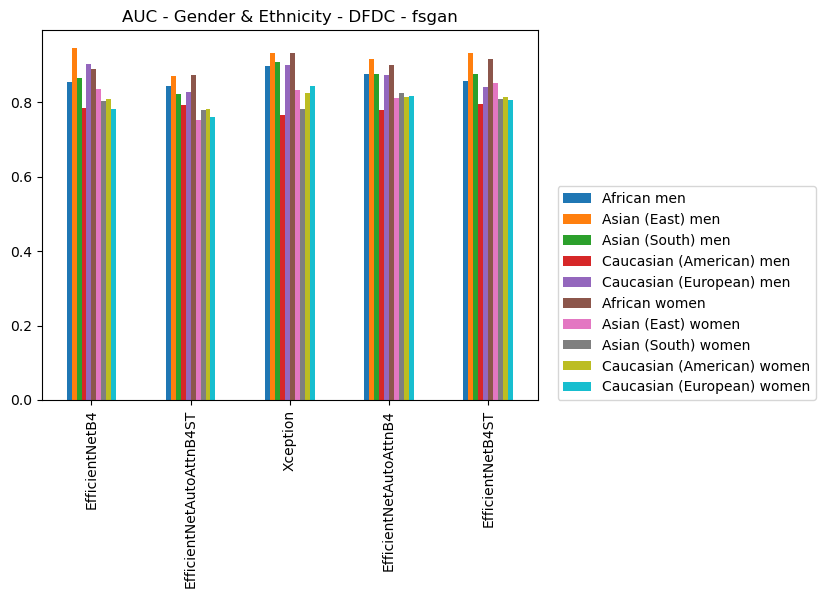

In [315]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
af_auc_m = []
ca_auc_m = []
ce_auc_m = []
ae_auc_m = []
as_auc_m = []
af_auc_f = []
ca_auc_f = []
ce_auc_f = []
ae_auc_f = []
as_auc_f = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'men')
    af_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'men')
    ae_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'men')
    as_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'men')
    ca_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'men')
    ce_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'women')
    af_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'women')
    ae_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'women')
    as_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'women')
    ca_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'women')
    ce_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African men':af_auc_m,
    'Asian (East) men':ae_auc_m,
    'Asian (South) men':as_auc_m,
    'Caucasian (American) men':ca_auc_m,
    'Caucasian (European) men':ce_auc_m,
    'African women':af_auc_f,
    'Asian (East) women':ae_auc_f,
    'Asian (South) women':as_auc_f,
    'Caucasian (American) women':ca_auc_f,
    'Caucasian (European) women':ce_auc_f,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Gender & Ethnicity - DFDC - fsgan')
plt.legend(loc=(1.04,0))
plt.show()

In [310]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
cols_to_select = ['model','ethnicity','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

            model             ethnicity gender  accuracy   auc-roc
9  EfficientNetB4  Caucasian (European)  women  0.700000  0.781600
1  EfficientNetB4          Asian (East)    men  0.679487  0.946429
                       model             ethnicity gender  accuracy  auc-roc
66  EfficientNetAutoAttnB4ST          Asian (East)  women  0.683673   0.7525
24    EfficientNetAutoAttnB4  Caucasian (European)    men  0.780000   0.8744
65  EfficientNetAutoAttnB4ST               African  women  0.780000   0.8744
       model             ethnicity gender  accuracy  auc-roc
43  Xception  Caucasian (American)    men      0.71   0.7668
45  Xception               African  women      0.80   0.9316
                     model             ethnicity gender  accuracy   auc-roc
23  EfficientNetAutoAttnB4  Caucasian (American)    men  0.700000  0.780000
21  EfficientNetAutoAttnB4          Asian (East)    men  0.769231  0.917143
               model             ethnicity gender  accuracy   auc-roc
83  Effici

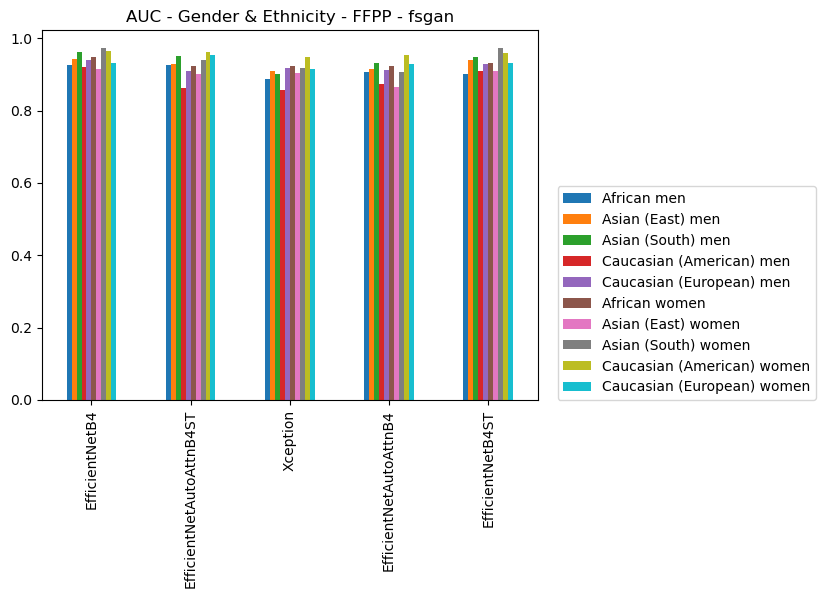

In [316]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
af_auc_m = []
ca_auc_m = []
ce_auc_m = []
ae_auc_m = []
as_auc_m = []
af_auc_f = []
ca_auc_f = []
ce_auc_f = []
ae_auc_f = []
as_auc_f = []

model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'men')
    af_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'men')
    ae_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'men')
    as_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'men')
    ca_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'men')
    ce_auc_m.append(temp_df[cond]['auc-roc'].values[0])
    
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='African') & (temp_df['gender'] == 'women')
    af_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (East)') & (temp_df['gender'] == 'women')
    ae_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Asian (South)') & (temp_df['gender'] == 'women')
    as_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (American)') & (temp_df['gender'] == 'women')
    ca_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    cond = (temp_df['model']==model) & (temp_df['ethnicity']=='Caucasian (European)') & (temp_df['gender'] == 'women')
    ce_auc_f.append(temp_df[cond]['auc-roc'].values[0])
    
d_b = pd.DataFrame({
    'African men':af_auc_m,
    'Asian (East) men':ae_auc_m,
    'Asian (South) men':as_auc_m,
    'Caucasian (American) men':ca_auc_m,
    'Caucasian (European) men':ce_auc_m,
    'African women':af_auc_f,
    'Asian (East) women':ae_auc_f,
    'Asian (South) women':as_auc_f,
    'Caucasian (American) women':ca_auc_f,
    'Caucasian (European) women':ce_auc_f,
})
d_b.index = model_names
d_b.plot.bar(title = 'AUC - Gender & Ethnicity - FFPP - fsgan')
plt.legend(loc=(1.04,0))
plt.show()

In [311]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
cols_to_select = ['model','ethnicity','gender','accuracy','auc-roc']
temp_dfs = []
model_names = [m.split('_')[0] for m in df_dict.keys()]
model_names = list(set(model_names))
for model in model_names:
    all_auc= temp_df[temp_df['model'] == model]['auc-roc'].values
    min_auc = min(all_auc)
    max_auc = max(all_auc)
    cond = (temp_df['auc-roc'] == min_auc) | (temp_df['auc-roc'] == max_auc)
    rows = temp_df[cond][cols_to_select].sort_values(by=['auc-roc'])
    temp_dfs.append(rows)
    
for df_ in temp_dfs:
    print(df_)

             model      ethnicity gender  accuracy  auc-roc
16  EfficientNetB4   Asian (East)  women  0.867347  0.91625
17  EfficientNetB4  Asian (South)  women  0.900000  0.97320
                       model             ethnicity gender  accuracy  auc-roc
53  EfficientNetAutoAttnB4ST  Caucasian (American)    men      0.71   0.8632
58  EfficientNetAutoAttnB4ST  Caucasian (American)  women      0.81   0.9612
       model             ethnicity gender  accuracy  auc-roc
93  Xception  Caucasian (American)    men      0.66   0.8568
98  Xception  Caucasian (American)  women      0.86   0.9468
                     model             ethnicity gender  accuracy  auc-roc
76  EfficientNetAutoAttnB4          Asian (East)  women   0.77551   0.8650
78  EfficientNetAutoAttnB4  Caucasian (American)  women   0.82000   0.9532
               model      ethnicity gender  accuracy  auc-roc
30  EfficientNetB4ST        African    men      0.79   0.9008
37  EfficientNetB4ST  Asian (South)  women      0.92   0.

<ipython-input-338-f7a057756d54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['subgroup'] = [x+' ' + y for x,y in zip(temp_df['ethnicity'].values,temp_df['gender'].values)]


<AxesSubplot:title={'center':'AUC Gender & Ethnicity DFDC_FFPP fsgan'}, xlabel='subgroup'>

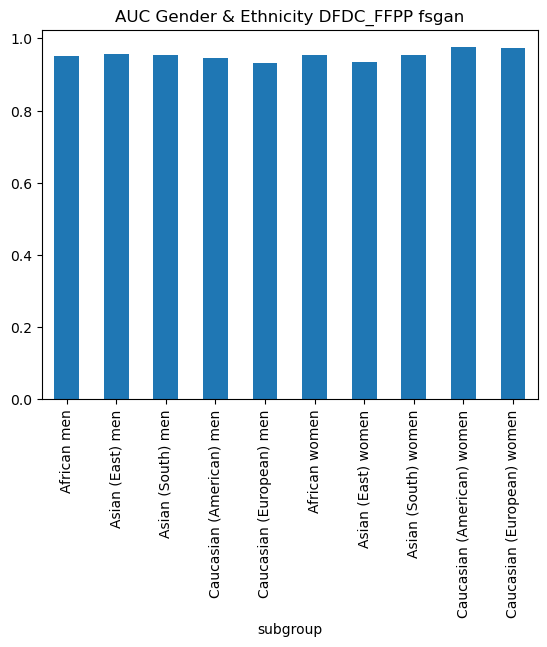

In [338]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df['subgroup'] = [x+' ' + y for x,y in zip(temp_df['ethnicity'].values,temp_df['gender'].values)]
temp_df.plot.bar(x='subgroup',y='auc-roc',title='AUC Gender & Ethnicity DFDC_FFPP fsgan',legend=False)

#### Groups with low to high accuracy ( models trained on DFDC )

In [321]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC']
temp_df.sort_values(by=['accuracy'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
63,EfficientNetAutoAttnB4ST,DFDC,men,Caucasian (American),0.650000,0.727273,0.611940,0.48,0.820000,0.578313,0.700855,"[0.0, 0.02, 0.18, 0.18, 0.24, 0.24, 0.36, 0.36...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.97580564, 0.97580564, 0.9374298, 0.9340442,...",0.793200
69,EfficientNetAutoAttnB4ST,DFDC,women,Caucasian (European),0.660000,0.614286,0.766667,0.86,0.460000,0.716667,0.575000,"[0.0, 0.02, 0.1, 0.1, 0.24, 0.24, 0.34, 0.34, ...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.1, 0...","[1.9662251, 0.9662251, 0.9260109, 0.8967308, 0...",0.760000
3,EfficientNetB4,DFDC,men,Caucasian (American),0.670000,0.729730,0.634921,0.54,0.800000,0.620690,0.707965,"[0.0, 0.02, 0.28, 0.28, 0.38, 0.38, 0.46, 0.46...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.1, 0...","[1.9977246, 0.9977246, 0.97652197, 0.97293764,...",0.783600
1,EfficientNetB4,DFDC,men,Asian (East),0.679487,0.962963,0.529412,0.52,0.964286,0.675325,0.683544,"[0.0, 0.03571428571428571, 0.5, 0.5, 0.75, 0.7...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9986447699999998, 0.99864477, 0.98773986, 0...",0.946429
89,EfficientNetB4ST,DFDC,women,Caucasian (European),0.680000,0.640625,0.750000,0.82,0.540000,0.719298,0.627907,"[0.0, 0.02, 0.12, 0.12, 0.18, 0.18, 0.28, 0.28...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9716143000000002, 0.9716143, 0.9424841, 0.9...",0.806800
66,EfficientNetAutoAttnB4ST,DFDC,women,Asian (East),0.683673,0.672727,0.697674,0.74,0.625000,0.704762,0.659341,"[0.0, 0.020833333333333332, 0.1666666666666666...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9461458999999999, 0.9461459, 0.9079253, 0.8...",0.752500
87,EfficientNetB4ST,DFDC,women,Asian (South),0.700000,0.666667,0.750000,0.80,0.600000,0.727273,0.666667,"[0.0, 0.02, 0.2, 0.2, 0.28, 0.28, 0.34, 0.34, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9806559, 0.9806559, 0.9420458, 0.930991, 0....",0.809600
62,EfficientNetAutoAttnB4ST,DFDC,men,Asian (South),0.700000,0.777778,0.656250,0.56,0.840000,0.651163,0.736842,"[0.0, 0.02, 0.14, 0.14, 0.32, 0.32, 0.46, 0.46...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.97498816, 0.97498816, 0.94630474, 0.9451262...",0.822000
23,EfficientNetAutoAttnB4,DFDC,men,Caucasian (American),0.700000,0.685185,0.717391,0.74,0.660000,0.711538,0.687500,"[0.0, 0.02, 0.22, 0.22, 0.24, 0.24, 0.28, 0.28...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99913764, 0.99913764, 0.960623, 0.95959383,...",0.780000
0,EfficientNetB4,DFDC,men,African,0.700000,0.812500,0.647059,0.52,0.880000,0.634146,0.745763,"[0.0, 0.02, 0.3, 0.3, 0.6, 0.6, 0.62, 0.62, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.08, 0.08, 0.1, 0...","[1.99936575, 0.99936575, 0.99213034, 0.9904442...",0.853600


#### Groups with low to high accuracy ( models trained on FFPP )

In [300]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
93,Xception,FFPP,men,Caucasian (American),0.660000,0.602564,0.863636,0.94,0.380000,0.734375,0.527778,"[0.0, 0.02, 0.24, 0.24, 0.3, 0.3, 0.34, 0.34, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9919451000000001, 0.9919451, 0.79872364, 0....",0.856800
53,EfficientNetAutoAttnB4ST,FFPP,men,Caucasian (American),0.710000,0.640000,0.920000,0.96,0.460000,0.768000,0.613333,"[0.0, 0.02, 0.4, 0.4, 0.46, 0.46, 0.48, 0.48, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.92681926, 0.92681926, 0.65576935, 0.5831508...",0.863200
76,EfficientNetAutoAttnB4,FFPP,women,Asian (East),0.775510,0.733333,0.842105,0.88,0.666667,0.800000,0.744186,"[0.0, 0.020833333333333332, 0.3125, 0.3125, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.08, ...","[1.9899360499999998, 0.98993605, 0.89789814, 0...",0.865000
73,EfficientNetAutoAttnB4,FFPP,men,Caucasian (American),0.690000,0.623377,0.913043,0.96,0.420000,0.755906,0.575342,"[0.0, 0.02, 0.32, 0.32, 0.34, 0.34, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.980648, 0.980648, 0.6908112, 0.68651915, 0....",0.873600
90,Xception,FFPP,men,African,0.750000,0.676056,0.931034,0.96,0.540000,0.793388,0.683544,"[0.0, 0.02, 0.2, 0.2, 0.44, 0.44, 0.54, 0.54, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9831378499999999, 0.98313785, 0.8723771, 0....",0.887200
30,EfficientNetB4ST,FFPP,men,African,0.790000,0.716418,0.939394,0.96,0.620000,0.820513,0.746988,"[0.0, 0.02, 0.5, 0.5, 0.62, 0.62, 0.64, 0.64, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.1, 0...","[1.98927325, 0.98927325, 0.67475027, 0.6375404...",0.900800
56,EfficientNetAutoAttnB4ST,FFPP,women,Asian (East),0.785714,0.737705,0.864865,0.90,0.666667,0.810811,0.752941,"[0.0, 0.020833333333333332, 0.5, 0.5, 0.520833...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9644192999999999, 0.9644193, 0.7305846, 0.7...",0.900833
92,Xception,FFPP,men,Asian (South),0.820000,0.750000,0.944444,0.96,0.680000,0.842105,0.790698,"[0.0, 0.02, 0.56, 0.56, 0.6, 0.6, 0.68, 0.68, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.1, 0...","[1.9960452, 0.9960452, 0.7075861, 0.6997643, 0...",0.901200
96,Xception,FFPP,women,Asian (East),0.816327,0.796296,0.840909,0.86,0.770833,0.826923,0.804348,"[0.0, 0.020833333333333332, 0.4166666666666667...","[0.0, 0.0, 0.0, 0.04, 0.04, 0.06, 0.06, 0.1, 0...","[1.9944159, 0.9944159, 0.8240254, 0.80134404, ...",0.903333
70,EfficientNetAutoAttnB4,FFPP,men,African,0.730000,0.653333,0.960000,0.98,0.480000,0.784000,0.640000,"[0.0, 0.02, 0.24, 0.24, 0.56, 0.56, 0.58, 0.58...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9802474, 0.9802474, 0.8095404, 0.79100597, ...",0.905600


#### Groups with low to high accuracy ( models trained on both DFDC and FFPP )

In [339]:
temp_df = gender_eth_accuracy_df[gender_eth_accuracy_df['training_dataset'] == 'DFDC_FFPP']
temp_df.sort_values(by=['auc-roc'])

,model,training_dataset,gender,ethnicity,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,tpr,fpr,thresholds-roc,auc-roc
104,CrossEffViT,DFDC_FFPP,men,Caucasian (European),0.870000,0.849057,0.893617,0.90,0.840000,0.873786,0.865979,"[0.0, 0.02, 0.5, 0.5, 0.64, 0.64, 0.72, 0.72, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.9999343, 0.9999343, 0.91717345, 0.9110939, ...",0.930800
106,CrossEffViT,DFDC_FFPP,women,Asian (East),0.826531,0.823529,0.829787,0.84,0.812500,0.831683,0.821053,"[0.0, 0.020833333333333332, 0.2708333333333333...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9999383, 0.9999383, 0.97223145, 0.9695839, ...",0.933333
103,CrossEffViT,DFDC_FFPP,men,Caucasian (American),0.880000,0.865385,0.895833,0.90,0.860000,0.882353,0.877551,"[0.0, 0.02, 0.34, 0.34, 0.44, 0.44, 0.64, 0.64...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.999933, 0.999933, 0.9623065, 0.9606824, 0.8...",0.944400
100,CrossEffViT,DFDC_FFPP,men,African,0.870000,0.911111,0.836364,0.82,0.920000,0.863158,0.876190,"[0.0, 0.02, 0.26, 0.26, 0.64, 0.64, 0.84, 0.84...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99995595, 0.99995595, 0.99566203, 0.9951516...",0.951600
107,CrossEffViT,DFDC_FFPP,women,Asian (South),0.870000,0.836364,0.911111,0.92,0.820000,0.876190,0.863158,"[0.0, 0.02, 0.3, 0.3, 0.74, 0.74, 0.8, 0.8, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.08, ...","[1.9999428, 0.9999428, 0.96291465, 0.952275, 0...",0.954400
105,CrossEffViT,DFDC_FFPP,women,African,0.850000,0.807018,0.906977,0.92,0.780000,0.859813,0.838710,"[0.0, 0.02, 0.74, 0.74, 0.76, 0.76, 0.78, 0.78...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.12, ...","[1.9999495, 0.9999495, 0.64861614, 0.6283152, ...",0.955200
102,CrossEffViT,DFDC_FFPP,men,Asian (South),0.840000,0.803571,0.886364,0.90,0.780000,0.849057,0.829787,"[0.0, 0.02, 0.64, 0.64, 0.72, 0.72, 0.74, 0.74...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.99992424, 0.99992424, 0.85767794, 0.8073393...",0.955200
101,CrossEffViT,DFDC_FFPP,men,Asian (East),0.923077,0.978261,0.843750,0.90,0.964286,0.937500,0.900000,"[0.0, 0.03571428571428571, 0.10714285714285714...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.08, ...","[1.99989057, 0.99989057, 0.9998119, 0.99694365...",0.957143
109,CrossEffViT,DFDC_FFPP,women,Caucasian (European),0.930000,0.921569,0.938776,0.94,0.920000,0.930693,0.929293,"[0.0, 0.02, 0.4, 0.4, 0.84, 0.84, 0.9, 0.9, 0....","[0.0, 0.0, 0.0, 0.02, 0.02, 0.04, 0.04, 0.06, ...","[1.9994220999999999, 0.9994221, 0.92281, 0.910...",0.974000
108,CrossEffViT,DFDC_FFPP,women,Caucasian (American),0.890000,0.830508,0.975610,0.98,0.800000,0.899083,0.879121,"[0.0, 0.02, 0.8, 0.8, 0.82, 0.82, 0.84, 0.84, ...","[0.0, 0.0, 0.0, 0.02, 0.02, 0.06, 0.06, 0.08, ...","[1.9997878999999998, 0.9997879, 0.54592556, 0....",0.974800
